<a href="https://colab.research.google.com/github/leochame/Computer-Study-Note/blob/main/llm/llms-from-srcatch/ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH02.01

In [ ]:
import os
import urllib.request

In [ ]:
with open("/content/llm-from-scratch/the-verdict.txt","r",encoding="utf-8") as f:
  raw_text = f.read()

In [ ]:
raw_text

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [ ]:
len(raw_text)

20479

In [ ]:
import re

text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)

# 先判断 item 是否为 None 或空字符串，再调用 .strip()
# `if item` 会过滤掉 None 和 ''
preprocessed = [item.strip() for item in result if item.strip()]

print(preprocessed)
# 输出: ['Hello', ',', 'world', '.', 'Is', 'this', 'a', 'test', '?']

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself', 'in', 'a', 'villa', 'on', 'the', 'Riviera', '.', '(', 'Though', 'I', 'rather', 'thought', 'it', 'would', 'have', 'been', 'Rome', 'or', 'Florence', '.', ')', '"', 'The', 'height', 'of', 'his', 'glory', '"', '--', 'that', 'was', 'what', 'the', 'women', 'called', 'it', '.', 'I', 'can', 'hear', 'Mrs', '.', 'Gideon', 'Thwing', '--', 'his', 'last', 'Chicago', 'sitter', '--', 'deploring', 'his', 'unaccountable', 'abdication', '.', '"', 'Of', 'course', 'it', "'", 's', 'going', 'to', 'send', 'the', 'value', 'of', 'my', 'picture', "'", 'way', 'up', ';', 'but', 'I', 'don', "'", 't', 'think', 'of', 'that', ',

In [ ]:
len(preprocessed)

4690

# CH02.02

In [ ]:
all_words = sorted(set(preprocessed))
len(all_words)

1130

# BPE


In [ ]:
import tiktoken

In [ ]:
tiktoken.__version__

'0.9.0'

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
tokenizer.encode("Hello world")

[15496, 995]

In [ ]:
 text = (
     "Hello, do you like tea? In the sunlit terraces"

 )
 tokenizer.encode("Hello world")

# 2.6 数据采样


In [ ]:
with open("/content/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [ ]:
import torch

In [ ]:
torch.__version__

'2.6.0+cu124'

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

# 2.7 创建词元嵌入

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])

In [ ]:
vocab_size = 6 # 为简单起见，假设我们有一张仅包含6个单词的小型词汇表，其实应该根据词汇的多少去设置
output_dim = 3 # 维度为3的嵌

可以利用vocab_size和output_dim在PyTorch中实例化一个嵌入层。此外，为了确保结果的可重复性，可以将随机种子设置为123：

In [ ]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


不用担心上方的数据都是随机的，因为其实他们还没有进行训练，他只是起始值

In [ ]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


嵌入层执行查找操作，即从它的权重矩阵中检索与特定词元ID对应的嵌入向量。例如，词元ID为5的嵌入向量位于嵌入层权重矩阵的第6行（因为Python的索引从0开始，所以它位于第6行而非第5行）​。假设这些词元ID是依据2.3节中的小词汇表产生的

In [ ]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


# 2.8


现在，我们将考虑更实际、更实用的嵌入维度，将输入的词元编码为256维的向量表示。虽然这个维度仍比原始GPT-3模型的维度（GPT-3模型的嵌入维度为12 288）要小，但对实验来说是合理的。

In [ ]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [ ]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


将这些 id 转换为向量，如下图

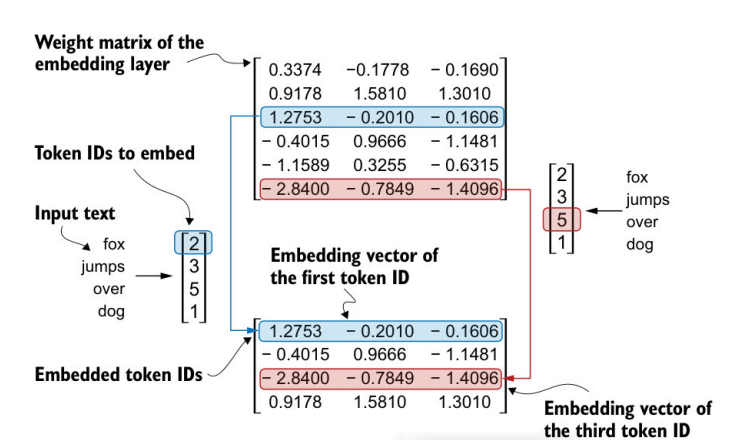

In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


【foxs jumps over foxs】这句话中的有两个foxs，在这里会对应一个向量。所以为了让这个词可以给大模型提供它的位置信息。而GPT模型所采用的绝对位置嵌入，只需创建一个维度与token_embedding_layer相同的嵌入层即可。这个叫做位置向量层

In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


接下来做的事情其实就是将位置向量层和token_embedding_layer相加

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
